In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

In [2]:
import os
import pickle
from time import gmtime, strftime
from functools import partial

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from transformers_clustering.helpers import TextDataset, purity_score, cluster_accuracy, callback_factory
from transformers_clustering.model import init_model, train, concat_cls_n_hidden_states, evaluate

In [3]:
n_epochs = 10
lr = 2e-5
train_batch_size = 16
val_batch_size = 32
gradient_accumulation_steps = 1
base_model = "distilbert-base-uncased"
clustering_loss_weight = 0.5
embedding_extractor = partial(concat_cls_n_hidden_states, n=5)
annealing_alphas = list(range(1, n_epochs + 1))
dataset = "../datasets/ag_news_subset5/ag_news_subset5.csv"
train_idx_file = "../datasets/ag_news_subset5/splits/train"
val_idx_file = "../datasets/ag_news_subset5/splits/validation"
result_dir = f"../results/embedding_plotting/{strftime('%Y-%m-%d_%H:%M:%S', gmtime())}"
early_stopping = True
early_stopping_tol = 0.01
device = "cuda:0"
random_state = 42

In [4]:
os.makedirs(result_dir)

In [5]:
from tqdm import tqdm

embedding_hist = {}
@callback_factory(embedding_hist=embedding_hist,  embedding_extractor=embedding_extractor)
def extract_embeddings(epoch, model, train_data_loader, *args, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    embeddings = []
    train_data_it = tqdm(train_data_loader, desc='Extracting embeddings')
    for batch_texts, batch_labels in train_data_it:
        inputs = model.tokenizer(list(batch_texts), return_tensors='pt', padding=True, truncation=True)
        inputs = inputs.to(model.device)
        
        true_labels.append(batch_labels.numpy().astype('int'))
        with torch.no_grad():
            lm_outputs = lm_model.base_model(**inputs)
            _, cluster_outputs = model(texts=list(batch_texts), inference=True)
        extracted_embeddings = embedding_extractor(lm_outputs).cpu().detach().numpy()
        embeddings.append(extracted_embeddings)
        predicted_labels.append(cluster_outputs.predicted_labels.numpy().astype('int'))
        
    embedding_hist[epoch] = {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'embeddings': np.vstack(embeddings)
    }
    return

In [6]:
# Set random states
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

# load data
df = pd.read_csv(dataset)

with open(train_idx_file, 'r') as f:
    train_idx = np.array(list(map(int, f.readlines())))

with open(val_idx_file, 'r') as f:
    val_idx = np.array(list(map(int, f.readlines())))

all_idx = np.concatenate((train_idx, val_idx))

df_train = df.iloc[all_idx].copy()

train_texts = df_train['texts'].to_numpy()
train_labels = df_train['labels'].to_numpy()

train_data = TextDataset(train_texts, train_labels)
train_data_loader = DataLoader(dataset=train_data, batch_size=train_batch_size, shuffle=False)


df_val = df.iloc[val_idx].copy()

val_texts = df_val['texts'].to_numpy()
val_labels = df_val['labels'].to_numpy()

val_data = TextDataset(val_texts, val_labels)
val_data_loader = DataLoader(dataset=val_data, batch_size=val_batch_size, shuffle=False)


# init lm model & tokenizer
lm_model = AutoModelForMaskedLM.from_pretrained(base_model, return_dict=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(base_model, return_dict=True, output_hidden_states=True)

lm_model.to(device)

# init clustering model
model, initial_centroids, initial_embeddings = init_model(
    lm_model=lm_model,
    tokenizer=tokenizer,
    data_loader=train_data_loader,
    embedding_extractor=embedding_extractor,
    n_clusters=np.unique(train_labels).shape[0],
    device=device
)

# init optimizer & scheduler
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=lr,  # 2e-5, 5e-7,
    eps=1e-8
)

total_steps = len(train_data_loader) * n_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=int(len(train_data_loader) * 0.5),
    num_training_steps=total_steps
)

In [7]:
# train the model
hist = train(
    n_epochs=n_epochs,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    annealing_alphas=annealing_alphas,
    train_data_loader=train_data_loader,
    clustering_loss_weight=clustering_loss_weight,
    early_stopping=early_stopping,
    early_stopping_tol=early_stopping_tol,
    verbose=True,
    on_epoch_end_callbacks=[extract_embeddings]
)

# do eval
run_results = {}

predicted_labels, true_labels = evaluate(
    model=model,
    eval_data_loader=val_data_loader,
    verbose=True
)

best_matching, accuracy = cluster_accuracy(true_labels, predicted_labels)
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
purity = purity_score(y_true=true_labels, y_pred=predicted_labels)

run_results['best_matching'] = best_matching
run_results['accuracy'] = accuracy
run_results['ari'] = ari
run_results['nmi'] = nmi
run_results['purity'] = purity  # use purity to compare with microsoft paper


# save results & model
with open(os.path.join(result_dir, 'train_hist.h'), 'wb') as f:
    pickle.dump(hist, file=f)

result_df = pd.DataFrame.from_records([run_results])
result_df.to_csv(os.path.join(result_dir, f'ag_news_subset5-distilbert.csv'), index=False)

torch.save(model, os.path.join(result_dir, 'model.bin'))

Epoch: 0 | CombLoss: 4.978194236755371 |LMLoss: 3.79398775100708 |  ClusterLoss: 6.162400245666504 | LR: 1.8944869427591665e-05 | Alpha: 1: 100%|██████████| 399/399 [00:57<00:00,  6.95it/s]    
Extracting embeddings:   1%|          | 3/399 [00:00<00:15, 24.99it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.8369905956112853)
adjusted_rand_score: 0.6270982179698419
normalized_mutual_info_score: 0.5903341060158882


Extracting embeddings: 100%|██████████| 399/399 [00:16<00:00, 23.82it/s]
Epoch: 1 | CombLoss: 3.505359172821045 |LMLoss: 2.623633623123169 |  ClusterLoss: 4.3870849609375 | LR: 1.6839883935637037e-05 | Alpha: 2: 100%|██████████| 399/399 [00:57<00:00,  6.90it/s]     
Extracting embeddings:   1%|          | 3/399 [00:00<00:15, 25.97it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.8429467084639498)
adjusted_rand_score: 0.6384823459800643
normalized_mutual_info_score: 0.5989253503431707


Extracting embeddings: 100%|██████████| 399/399 [00:16<00:00, 23.49it/s]
Epoch: 2 | CombLoss: 3.093301773071289 |LMLoss: 2.794589042663574 |  ClusterLoss: 3.392014741897583 | LR: 1.4734898443682407e-05 | Alpha: 3: 100%|██████████| 399/399 [00:58<00:00,  6.87it/s]   
Extracting embeddings:   1%|          | 3/399 [00:00<00:16, 24.57it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.845141065830721)
adjusted_rand_score: 0.6422146771381388
normalized_mutual_info_score: 0.6092214458820523


Extracting embeddings: 100%|██████████| 399/399 [00:16<00:00, 23.82it/s]
Epoch: 3 | CombLoss: 3.118774890899658 |LMLoss: 3.392852544784546 |  ClusterLoss: 2.8446974754333496 | LR: 1.2629912951727777e-05 | Alpha: 4: 100%|██████████| 399/399 [00:57<00:00,  6.89it/s]  
Extracting embeddings:   1%|          | 3/399 [00:00<00:15, 26.27it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.8457680250783699)
adjusted_rand_score: 0.6437329353711114
normalized_mutual_info_score: 0.6050775537827088


Extracting embeddings: 100%|██████████| 399/399 [00:16<00:00, 23.63it/s]
Epoch: 4 | CombLoss: 2.7765064239501953 |LMLoss: 2.992997407913208 |  ClusterLoss: 2.5600156784057617 | LR: 1.0524927459773148e-05 | Alpha: 5: 100%|██████████| 399/399 [00:57<00:00,  6.90it/s] 
Extracting embeddings:   1%|          | 3/399 [00:00<00:15, 26.22it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.8454545454545455)
adjusted_rand_score: 0.6433490022930363
normalized_mutual_info_score: 0.6058688103015317


Extracting embeddings: 100%|██████████| 399/399 [00:17<00:00, 23.38it/s]
Epoch: 5 | CombLoss: 2.5134899616241455 |LMLoss: 2.762040138244629 |  ClusterLoss: 2.264939785003662 | LR: 8.419941967818518e-06 | Alpha: 6: 100%|██████████| 399/399 [00:57<00:00,  6.90it/s]  
Extracting embeddings:   1%|          | 3/399 [00:00<00:14, 26.91it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.8432601880877743)
adjusted_rand_score: 0.639113599444894
normalized_mutual_info_score: 0.6097099616706583


Extracting embeddings: 100%|██████████| 399/399 [00:17<00:00, 23.41it/s]
Epoch: 6 | CombLoss: 2.3205959796905518 |LMLoss: 2.360870361328125 |  ClusterLoss: 2.2803215980529785 | LR: 6.314956475863888e-06 | Alpha: 7: 100%|██████████| 399/399 [00:57<00:00,  6.90it/s]  
Extracting embeddings:   1%|          | 3/399 [00:00<00:16, 23.61it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.845141065830721)
adjusted_rand_score: 0.6434725170163688
normalized_mutual_info_score: 0.6061411367030364


Extracting embeddings: 100%|██████████| 399/399 [00:16<00:00, 23.54it/s]
Epoch: 7 | CombLoss: 2.3235764503479004 |LMLoss: 2.6318280696868896 |  ClusterLoss: 2.015324831008911 | LR: 4.209970983909259e-06 | Alpha: 8: 100%|██████████| 399/399 [00:58<00:00,  6.86it/s]  
Extracting embeddings:   1%|          | 3/399 [00:00<00:17, 23.24it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.846551724137931)
adjusted_rand_score: 0.6466897730433759
normalized_mutual_info_score: 0.6112730204463257


Extracting embeddings: 100%|██████████| 399/399 [00:16<00:00, 23.79it/s]
Epoch: 8 | CombLoss: 2.697672128677368 |LMLoss: 3.4341444969177246 |  ClusterLoss: 1.9611997604370117 | LR: 2.1049854919546296e-06 | Alpha: 9: 100%|██████████| 399/399 [00:57<00:00,  6.91it/s] 
Extracting embeddings:   1%|          | 3/399 [00:00<00:15, 25.43it/s]

cluster_accuracy: ({0: 0, 1: 3, 2: 1, 3: 2}, 0.846551724137931)
adjusted_rand_score: 0.646093826910856
normalized_mutual_info_score: 0.6094734655270203


Eval:  20%|██        | 4/20 [00:00<00:00, 31.68it/s]

0.007836990595611285 % of Cluster assignments changed over the course of one epoch. Early stopping!


Eval: 100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


In [8]:
with open(os.path.join(result_dir, 'embedding_hist.h'), 'wb') as f:
    pickle.dump(embedding_hist, f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from pandas import read_csv


#Scatter of Petal
x=df['PetalLength']
y=df['PetalWidth']
def plot_embeddings(x, y, labels):
    # Get unique names of species
    uniq = list(set(labels))

    # Set the color map to match the number of species
    z = range(1,len(uniq))
    hot = plt.get_cmap('hot')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    # Plot each species
    for i in range(len(uniq)):
        indx = df['Name'] == uniq[i]
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])

    plt.xlabel('Petal Width')
    plt.ylabel('Petal Length')
    plt.title('Petal Width vs Length')
    plt.legend(loc='upper left')
    plt.show()

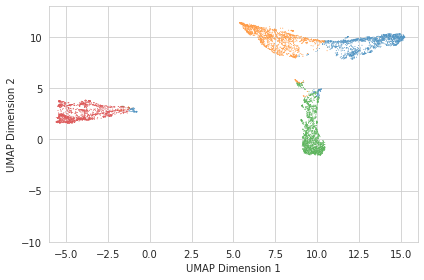

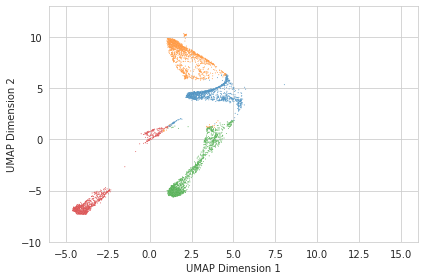

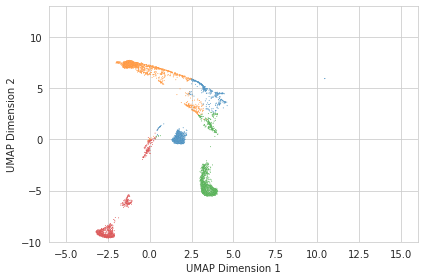

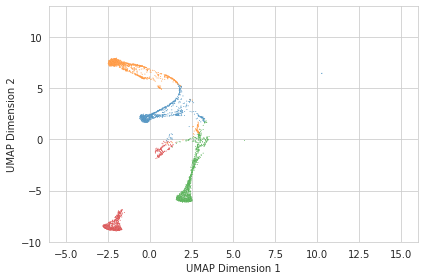

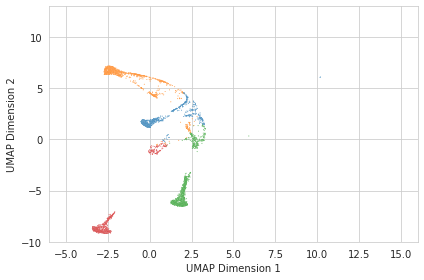

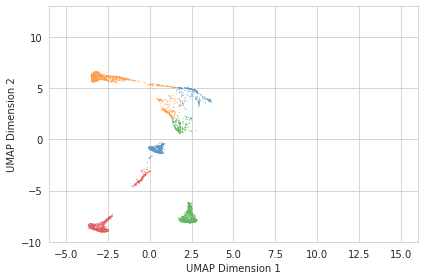

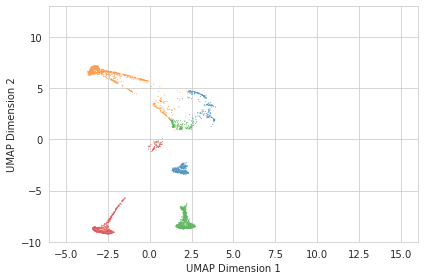

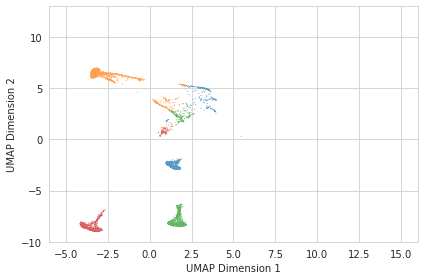

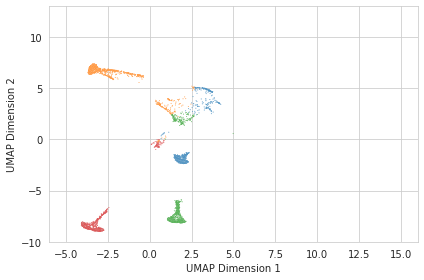

In [64]:
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain


#umap = UMAP(n_components=2, n_jobs=12)
umap = UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
)
for epoch, data in embedding_hist.items():
    plt.figure(epoch)
    sns.reset_orig()
    sns.set_style("whitegrid")
    if epoch == 0:
        Xr = umap.fit_transform(data['embeddings'])
    else:
        Xr = umap.transform(data['embeddings'])
    true_labels = np.array(list(chain(*data['true_labels'])))
    predicted_labels = np.array(list(chain(*data['predicted_labels'])))
    plot_data = {'UMAP Dimension 1': Xr[:,0], 'UMAP Dimension 2': Xr[:,1], 'True Class':[f'Class {i}' for i in true_labels], 'Predicted cluster': [f'Cluster {i}' for i in predicted_labels]}
    plot_df = pd.DataFrame(plot_data)
    plot = sns.scatterplot(x='UMAP Dimension 1', y='UMAP Dimension 2', hue='Predicted cluster', data=plot_df,  s=0.8, legend=False)
    plot.set(xlim=(-6, 16), ylim=(-10, 13))
    #plot.legend(False)
    plt.tight_layout()
    fig = plot.get_figure()
    fig.savefig(os.path.join(result_dir, f'epoch{epoch}.png'), dpi=300)

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain


#umap = UMAP(n_components=2, n_jobs=12, n_neighbors=25, min_dist=0.5)
umap = UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
)
for epoch, data in embedding_hist.items():
    plt.figure(epoch)
    sns.reset_orig()
    sns.set_style("whitegrid")
    Xr = umap.fit_transform(data['embeddings'])
    true_labels = np.array(list(chain(*data['true_labels'])))
    predicted_labels = np.array(list(chain(*data['predicted_labels'])))
    plot_data = {'x': Xr[:,0], 'y': Xr[:,1], 'True Class':[f'Class {i}' for i in true_labels], 'Predicted cluster': [f'Cluster {i}' for i in predicted_labels]}
    plot_df = pd.DataFrame(plot_data)
    plot = sns.scatterplot(x='x', y='y', hue='Predicted cluster', data=plot_df, s=0.8)
    plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plot.set(xlim=(-20, 20), ylim=(-20, 20))
    plt.tight_layout()
    fig = plot.get_figure()
    fig.savefig(os.path.join(result_dir, f'epoch{epoch}_newfit.png'), dpi=300)

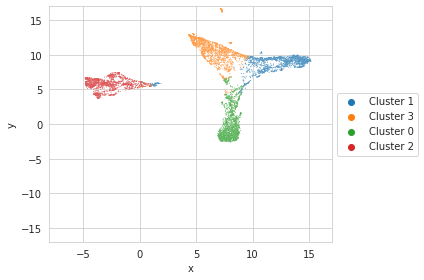

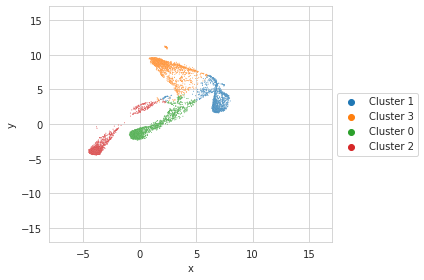

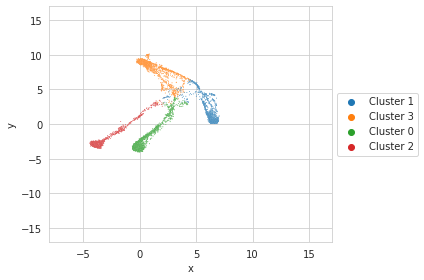

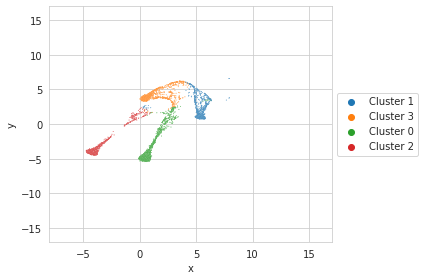

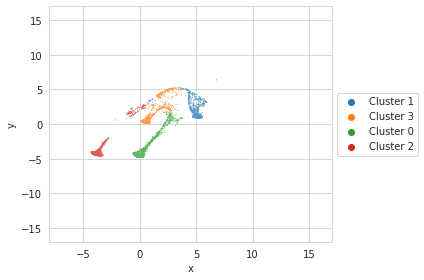

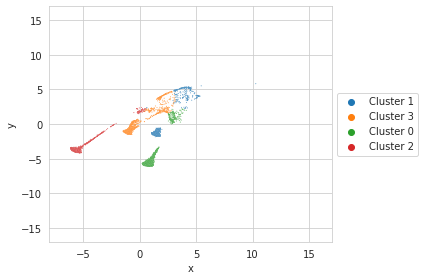

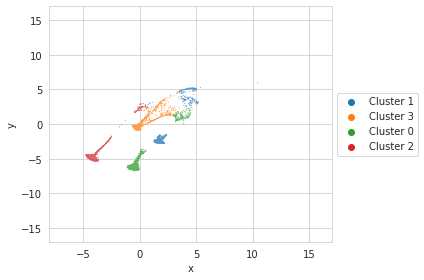

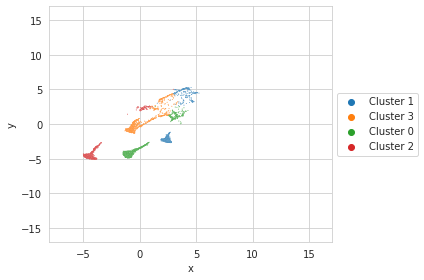

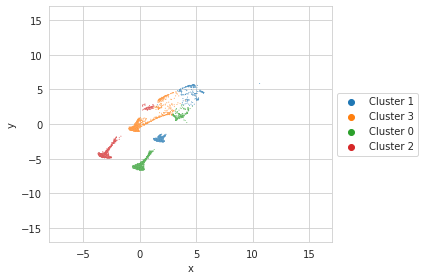

In [52]:
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain


umap = UMAP(n_components=2, n_jobs=12)

for epoch, data in embedding_hist.items():
    plt.figure(epoch)
    sns.reset_orig()
    sns.set_style("whitegrid")
    if epoch == 0:
        Xr = umap.fit_transform(data['embeddings'])
    else:
        Xr = umap.transform(data['embeddings'])
    true_labels = np.array(list(chain(*data['true_labels'])))
    predicted_labels = np.array(list(chain(*data['predicted_labels'])))
    plot_data = {'x': Xr[:,0], 'y': Xr[:,1], 'True Class':[f'Class {i}' for i in true_labels], 'Predicted cluster': [f'Cluster {i}' for i in predicted_labels]}
    plot_df = pd.DataFrame(plot_data)
    plot = sns.scatterplot(x='x', y='y', hue='Predicted cluster', data=plot_df, s=0.8)
    plot.set(xlim=(-8, 17), ylim=(-17, 17))
    plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    fig = plot.get_figure()
    fig.savefig(os.path.join(result_dir, f'epoch{epoch}_alt.png'), dpi=300)

In [56]:
print("yo")

yo
